In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import evosax

import json


In [5]:
import xylo
import xylo.types as t
import xylo.woods
import xylo.cut

import xylo.opt

import xylo.tuning
import xylo.database
import xylo.just

In [6]:
layout = xylo.just.bass_partch
bar_thick = xylo.types.BarProps(width = 0.090, min_depth=0.002, depth=0.020, length = 1.000, elements = 10)
mat = xylo.woods.spotted_gum

tuning = xylo.tuning.yamaha_YX500R

In [18]:
depth = 25

def mk_geom(note):
  bar = bar_thick
  return xylo.database.Geometry(width = bar.width * 1000, length = bar.length * 1000, depth = depth, weight = 1)

geom0 = { k: mk_geom(k) for k in layout.rows.keys() }

# geom0 = xylo.just.diamond_11_partch_geom


def get_db():
  return xylo.database.get(geom0, f'data/db-bass-d{depth}.json')
def with_db(act):
  return xylo.database.with_db(act, geom0, f'data/db-bass-d{depth}.json')

In [55]:
with_db(lambda db: db.clear_loss_all())

In [56]:
geom0

{'A#3': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'A3': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'F#3': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'F3': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'D#3': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'C#3': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'A2': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'G2': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'E2': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'D2': Geometry(length=1000.0, width=90.0, depth=25, weight=1),
 'C2': Geometry(length=1000.0, width=90.0, depth=25, weight=1)}

In [62]:
init_mean = None
sum_lengths = 0
for num_dims in [3,5,3,5,3,5,3,5,3,5,3,5]: # range(3,10):
  options = xylo.opt.Options(num_generations = 10, strategy = evosax.OpenES(popsize = 2000, num_dims = num_dims), absolute_tolerance = 1e-5)

  for note in layout.rows.keys():
    db = get_db()
    match db.get_best_for_dims(note, num_dims):
      case None:
        pass
      case e:
        init_mean = e

    options_ = options._replace(init_mean = init_mean)
    # options_ = options

    bar = db.get_bar(note, elements = 100)
    # bar = bar_default._replace(length = len)
    # bar = t.BarProps(width = 0.) db.get_bar(note)
    # wood = db.get_wood(note)

    freq = layout.reference_hz * layout.rows[note]
    partials = [1.0, 4.0, 8.0]
    weights = [tuning.weight(freq), tuning.weight(freq * partials[1]) * 0.5, tuning.weight(freq * partials[2]) * 0.4]

    sol = xylo.opt.optimize_geometry_length(bar, mat, options_, freq, jnp.array(partials), jnp.array(weights), weight_len=2.0)
    spline = sol.best_member

    with_db(lambda db: db.set_best_for_dims(note, num_dims, sol.best_member.tolist(), sol.best_fitness.tolist()))

    init_mean = sol.best_member

    spline, len = init_mean[0:-1], init_mean[-1]
    # spline, len = init_mean, 1
    barx = bar._replace(length = bar.length * len)
    section = xylo.cut.spline(barx, spline)
    swp = xylo.sweep.sweep(mat, barx, section, t.sweep_default)

    sum_lengths += barx.length

    print(note, freq)
    print("---------------")
    print(swp.harmonics / freq, barx.length, init_mean)
    print("")

print("total length: ", sum_lengths)

iteration 0
[0.32189202 0.62820643 0.51304342] 1.1095401
[ 224.01035624  917.43124361 2111.22292763] [0.97963713 4.01208999 9.23275333] 0.5130434172426409
A#3 228.66666666666669
---------------
[0.99262067 3.9703601  9.0394981 ] 0.5174844356386241 [0.34101993 0.64541784 0.51748444]

iteration 0
[0.         1.         0.36786888] 0.9661643
[ 196.0860389   779.28840578 2035.21936642] [0.88927909 3.53418778 9.2300198 ] 0.36786888435226744
A3 220.5
---------------
[0.88945178 3.53486714 9.23179409] 0.3678328459258324 [0.         1.         0.36783285]

iteration 0
[0.         1.         0.40818322] 1.0486058
[ 159.52798926  634.87721506 1659.5996515 ] [0.88791089 3.53363942 9.23710381] 0.40818322399917106
F#3 179.66666666666666
---------------
[0.88807051 3.53427241 9.23874993] 0.40814618912501 [0.         1.         0.40814619]

iteration 0
[0.        1.        0.4145938] 1.061562
[ 154.66665971  615.64463702 1609.52367525] [0.88775506 3.53367457 9.23833742] 0.4145938046741922
F3 174.2222

[0.0, 1.0, 0.679887558833852]
C2 0.679887558833852
[0.88292609 3.5138439  9.19185636] 65.33333333333333


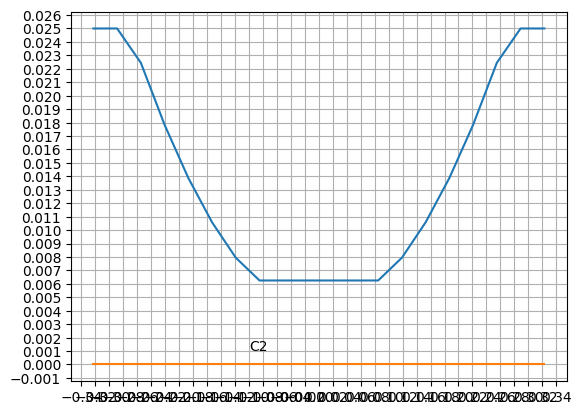

In [28]:
import matplotlib.ticker as plticker
for note in ['C2']: # layout.rows.keys():
  db = get_db()
  bar = db.get_bar(note, elements = 20)
  fundamental = layout.reference_hz * layout.rows[note]
  len_mul = 0.5
  params = db.get_best_for_dims(note, 3)
  # params = db.get_best(note)['coeff']
  print(params)
  spline, len = params[0:-1], params[-1]

  section = xylo.cut.spline(bar._replace(length = bar.length * len), jnp.array(spline))
  section.plot(to_scale = False)
  print(note, bar.length * len)
  swp = xylo.sweep.sweep(mat, bar, section, t.sweep_default)
  print(swp.harmonics / fundamental, fundamental)
  plt.grid()
  ax = plt.gca()
  locx = plticker.MultipleLocator(base=0.02)
  locy = plticker.MultipleLocator(base=0.001)
  ax.xaxis.set_major_locator(locx)
  ax.yaxis.set_major_locator(locy)
  plt.text(-0.1, 0.001, note)
  # plt.gca()

In [37]:
# geom0 = xylo.just.diamond_11_partch_geom
# for k, v in layout.rows.items():
#   print(k, geom0[k].length, geom0[k].width, v * layout.reference_hz)